## **Analysis of the elevation change rate drived by dems.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
import h5py
from utils.ransac_filter import ransac_filter


In [2]:
paths_stat_dems = 'data/aster-stereo/stat_elev_dif_glacier.h5'   ## path to save
years = [ str(year) for year in range(2003,2022)]   ## 


In [3]:
# !h5ls $paths_stat_dems
!h5ls $paths_stat_dems/tile_27_96


glacier_area_bins        Group
mean_dif_bins            Group
std_dif_bins             Group


#### 1. Read glacier elevation change data.


In [4]:
import xarray as xr
### read bin-based mean elevation change data
with h5py.File(paths_stat_dems, "r") as f:
  tiles_id = list(f.keys())
  bins_id = list(f[tiles_id[0]+'/glacier_area_bins'].keys())
  mean_tiles_bins = np.empty(shape=(len(tiles_id), len(bins_id), len(years)))
  std_tiles_bins = np.empty(shape=(len(tiles_id), len(bins_id), len(years)))
  glacier_area_bins = np.empty(shape=(len(tiles_id), len(bins_id)))
  for i_tile, tile_id in enumerate(tiles_id):  
    for i_bin, bin_id in enumerate(bins_id):
      glacier_area_bins[i_tile][i_bin] = f[tile_id + '/glacier_area_bins/' + bin_id][:]  
      mean_tiles_bins[i_tile][i_bin] = f[tile_id + '/mean_dif_bins/' + bin_id][:]      
      std_tiles_bins[i_tile][i_bin] = f[tile_id + '/std_dif_bins/' + bin_id][:]      

### conver to xarray data.
mean_tiles_bins_xr =xr.Dataset(
        {"glacier_area_bins": (["tiles_id", "bins_id"], glacier_area_bins),          
          "mean_tiles_bins": (["tiles_id", "bins_id", "time"], mean_tiles_bins),         
          "std_tiles_bins": (["tiles_id", "bins_id", "time"], std_tiles_bins),         
         },
        coords={'tiles_id': tiles_id,
                'bins_id': bins_id,
                'time': years})
mean_tiles_bins_xr


<xarray.Dataset>
Dimensions:            (tiles_id: 28, bins_id: 50, time: 19)
Coordinates:
  * tiles_id           (tiles_id) <U10 'tile_27_96' ... 'tile_31_95'
  * bins_id            (bins_id) <U9 '2500_2600' '2600_2700' ... '7400_7500'
  * time               (time) <U4 '2003' '2004' '2005' ... '2019' '2020' '2021'
Data variables:
    glacier_area_bins  (tiles_id, bins_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mean_tiles_bins    (tiles_id, bins_id, time) float64 nan nan nan ... nan nan
    std_tiles_bins     (tiles_id, bins_id, time) float64 nan nan nan ... nan nan

#### 2. Data filtering for time-series data by using ransac algorithm.

In [5]:
def data_filter(mean_tiles_bins_xr, ransac_thre=5, std_thre=30):
    """
    des: elevation change filtering by ransac algorithm and standard deviation.
    args:
        mean_tiles_bins_xr: xarray.dataset, the dataset should contain the xr.dataarray of mean_tiles_bins.
        ransac_thre: False or value, threshold for ransac filtering.
        std_thre: False or value, threshold for filtering by standard deviation.
    return: 
        mean_tiles_bins_xr, xarray.dataset, the new dataset with the filtered data.
    """
    mean_tiles_bins_filter = mean_tiles_bins_xr.copy(deep=True)
    tiles_id = mean_tiles_bins_filter.tiles_id.values
    bins_id = mean_tiles_bins_filter.bins_id.values
    years = mean_tiles_bins_filter.time.values
    x = np.array([i for i in range(len(years))])
    mean_tiles_bins_filter_da = mean_tiles_bins_filter['mean_tiles_bins'].copy()    ## xr.dataarray
    for tile_id in tiles_id:
        for bin_id in bins_id:
            y = mean_tiles_bins_filter['mean_tiles_bins'].sel(tiles_id=tile_id, bins_id=bin_id).values
            if std_thre is not None:
                y_std = mean_tiles_bins_filter['std_tiles_bins'].sel(tiles_id=tile_id, bins_id=bin_id).values
                id_std = np.where(y_std>std_thre)[0]     ### filtering by standard deviation.
                y[id_std] = np.nan
                mean_tiles_bins_filter_da.loc[dict(tiles_id=tile_id, bins_id=bin_id)] = y
            if ransac_thre is not None:
                if y[~np.isnan(y)].shape[0]<4:
                    continue
                else:
                    y_filter, y_ransac_fit, ransac_cof = ransac_filter(x=x, y=y, thre=ransac_thre)
                mean_tiles_bins_filter_da.loc[dict(tiles_id=tile_id, bins_id=bin_id)] = y_filter  ## update filtered data
    mean_tiles_bins_filter['mean_tiles_bins_filter'] = mean_tiles_bins_filter_da
    return mean_tiles_bins_filter

 

#### 3. Glacier area-weighted elevation change.


In [6]:
def ele_change_weighting(mean_tiles_bins, std_tiles_bins, glacier_area_tiles_bins):
    """
    des: glacier area-weighted elevation change calculation.
    !!! bins-based glacier area weighting -> tiles-based glacier area weighting.
    args:
        mean_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), mean elevation change for each bin of each tile.
        std_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), standard deviation of elevation change for each bin of each tile.
        glacier_area_bins: xarray.DataArray, (tiles_id, bins_id), glacier area for each bin of each tile.
    return: 
        mean_tiles_weighted: xr.dataarray, glacier-area weighted mean elevation change for each tile. 
        mean_setp_weighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
    """
    ### a) glacier area (bin-based) weighted mean elevation change for each tile.
    glacier_area_tiles_bins_3d = glacier_area_tiles_bins.expand_dims(dim={"time": years}, axis=2)
    glacier_area_tiles_bins_3d = ~np.isnan(mean_tiles_bins)*glacier_area_tiles_bins_3d  ## mask the nan values before area weighting
    glacier_area_tiles_2d = glacier_area_tiles_bins_3d.sum(dim=('bins_id'))
    glacier_area_tiles_3d = glacier_area_tiles_2d.expand_dims(dim={'bins_id': bins_id}, axis=1)
    glacier_area_binsWeight_3d = glacier_area_tiles_bins_3d/glacier_area_tiles_3d   ## (tiles_id, bins_id, years), weights for each bin of each year.
    mean_tiles_binWeighted = mean_tiles_bins * glacier_area_binsWeight_3d.values  
    mean_tiles_binWeighted = mean_tiles_binWeighted.sum(dim=('bins_id'))       ## (tiles_id, years)
    mean_tiles_binWeighted = mean_tiles_binWeighted.where(mean_tiles_binWeighted!=0, np.nan)  # if values == 0, value -> np.nan. 
    std_tiles_binWeighted = std_tiles_bins * glacier_area_binsWeight_3d
    std_tiles_binWeighted = std_tiles_binWeighted.sum(dim=('bins_id'))       ## (tiles_id, years)
    ### b) glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_tiles = glacier_area_tiles_bins.sum(dim='bins_id')   ###（tiles_id,）
    glacier_area_tiles_2d = glacier_area_tiles.expand_dims(dim={'times': years}, axis=1)  ## (tiles_id, years)
    glacier_area_tiles_2d = ~np.isnan(mean_tiles_binWeighted)*glacier_area_tiles_2d.values  ## (tiles_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_tiles_2d.sum(dim=('tiles_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)   ### (tiles_id, years)    
    glacier_area_tilesWeight_2d = glacier_area_tiles_2d/glacier_area_2d   ### (tiles_id, years)
    mean_setp_tilesWeighted = mean_tiles_binWeighted*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    mean_setp_tilesWeighted = mean_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    std_setp_tilesWeighted = std_tiles_binWeighted*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    std_setp_tilesWeighted = std_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    return mean_tiles_binWeighted, std_tiles_binWeighted, mean_setp_tilesWeighted, std_setp_tilesWeighted


def ele_change_weighting_(mean_tiles_bins, std_tiles_bins, glacier_area_tiles_bins):
    """
    des: glacier area-weighted elevation change calculation.  
         !!! tiles-based glacier area weighting -> bins-based glacier area weighting.
    args:
        mean_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), mean elevation change for each bin of each tile.
        std_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), standard deviation of elevation change for each bin of each tile.
        glacier_area_tiles_bins: xarray.DataArray, (tiles_id, bins_id), glacier area for each bin of each tile.
    return: 
        mean_tiles_weighted: xr.dataarray, glacier-area weighted mean elevation change for each tile. 
        mean_setp_weighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
    """
    glacier_area_tiles_bins_3d = glacier_area_tiles_bins.expand_dims(dim={"time": years}, axis=2)
    glacier_area_tiles_bins_3d = ~np.isnan(mean_tiles_bins)*glacier_area_tiles_bins_3d.values   ## mask the nan values before area weighting
    glacier_area_bins_2d = glacier_area_tiles_bins_3d.sum(dim=('tiles_id'))   ### (bins_id, years), sumation of area for each bin of setp.
    glacier_area_bins_3d = glacier_area_bins_2d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)  ## (tiles_id, bins_id, years)
    glacier_area_tilesWeight_3d = glacier_area_tiles_bins_3d/glacier_area_bins_3d.values   ### weights for each bin of setp  
    mean_bins_tilesWeighted_3d = mean_tiles_bins*glacier_area_tilesWeight_3d.values
    mean_bins_tilesWeighted = mean_bins_tilesWeighted_3d.sum(dim='tiles_id')   ### (bins_id, years)
    std_bins_tilesWeighted_3d = std_tiles_bins*glacier_area_tilesWeight_3d.values
    std_bins_tilesWeighted = std_bins_tilesWeighted_3d.sum(dim='tiles_id')   ### (bins_id, years)

    ### b) glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_bins = glacier_area_tiles_bins.sum(dim='tiles_id')   ###（bins_id,）
    glacier_area_bins_2d = glacier_area_bins.expand_dims(dim={'times': years}, axis=1)  ## (bins_id, years)
    glacier_area_bins_2d = ~np.isnan(mean_bins_tilesWeighted)*glacier_area_bins_2d.values  ## (bins_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_bins_2d.sum(dim=('bins_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'bins_id': bins_id}, axis=0)   ### (bins_id, years)    
    glacier_area_binsWeight_2d = glacier_area_bins_2d/glacier_area_2d   ### (bins_id, years)
    mean_setp_binsWeighted = mean_bins_tilesWeighted*glacier_area_binsWeight_2d    ## (bins_id, years)
    mean_setp_binsWeighted = mean_setp_binsWeighted.sum(dim=('bins_id'))     ## (years,)   
    std_setp_binsWeighted = std_bins_tilesWeighted*glacier_area_binsWeight_2d    ## (bins_id, years)
    std_setp_binsWeighted = std_setp_binsWeighted.sum(dim=('bins_id'))     ## (years,)   
    return mean_bins_tilesWeighted, std_bins_tilesWeighted, mean_setp_binsWeighted, std_setp_binsWeighted




#### 3. Visualize elevation change of overall setp.


In [7]:
mean_tiles_bins_std = data_filter(mean_tiles_bins_xr=mean_tiles_bins_xr, ransac_thre=None, std_thre=20)
mean_tiles_bins_ransac = data_filter(mean_tiles_bins_xr=mean_tiles_bins_xr, ransac_thre=5, std_thre=None)
mean_tiles_bins_filter = data_filter(mean_tiles_bins_xr=mean_tiles_bins_xr, ransac_thre=5, std_thre=20)

mean_tiles_binsWeighted, std_tiles_binsWeighted, mean_setp_tilesWeighted, std_setp_tilesWeighted = \
                            ele_change_weighting(mean_tiles_bins=mean_tiles_bins_xr['mean_tiles_bins'], \
                                                std_tiles_bins=mean_tiles_bins_xr['std_tiles_bins'], 
                                                glacier_area_tiles_bins=mean_tiles_bins_xr['glacier_area_bins'])

mean_tiles_binsWeighted_ransac, std_tiles_binsWeighted_ransac, mean_setp_tilesWeighted_ransac, std_setp_tilesWeighted_ransac = \
                            ele_change_weighting(mean_tiles_bins=mean_tiles_bins_ransac['mean_tiles_bins_filter'], \
                                                std_tiles_bins=mean_tiles_bins_xr['std_tiles_bins'], \
                                                glacier_area_tiles_bins=mean_tiles_bins_xr['glacier_area_bins'])

mean_tiles_binsWeighted_std, std_tiles_binsWeighted_std, mean_setp_tilesWeighted_std, std_setp_tilesWeighted_std = \
                            ele_change_weighting(mean_tiles_bins=mean_tiles_bins_std['mean_tiles_bins_filter'], \
                                                 std_tiles_bins=mean_tiles_bins_xr['std_tiles_bins'], \
                                                glacier_area_tiles_bins=mean_tiles_bins_xr['glacier_area_bins'])

mean_tiles_binsWeighted_filter, std_tiles_binsWeighted_filter, mean_setp_tilesWeighted_filter, std_setp_tilesWeighted_filter = \
                            ele_change_weighting(mean_tiles_bins=mean_tiles_bins_filter['mean_tiles_bins_filter'], \
                                                 std_tiles_bins=mean_tiles_bins_xr['std_tiles_bins'], \
                                                glacier_area_tiles_bins=mean_tiles_bins_xr['glacier_area_bins'])



In [8]:
# x_years = np.array([i for i in range(len(years))])
# y_filtered, y_fitting, ransac_coef = ransac_filter(x=x_years, y=mean_setp_tilesWeighted_filter.values, thre=5)
# # print(mean_setp_tilesWeighted.values)
# print(ransac_coef)
# plt.figure(figsize=(15,5))
# plt.plot(x_years, mean_setp_tilesWeighted.values, '-g')
# plt.plot(x_years, y_filtered, '-b')
# plt.plot(x_years, y_fitting, '-r')


Text(0.5, 1.0, 'elevation change for setp')

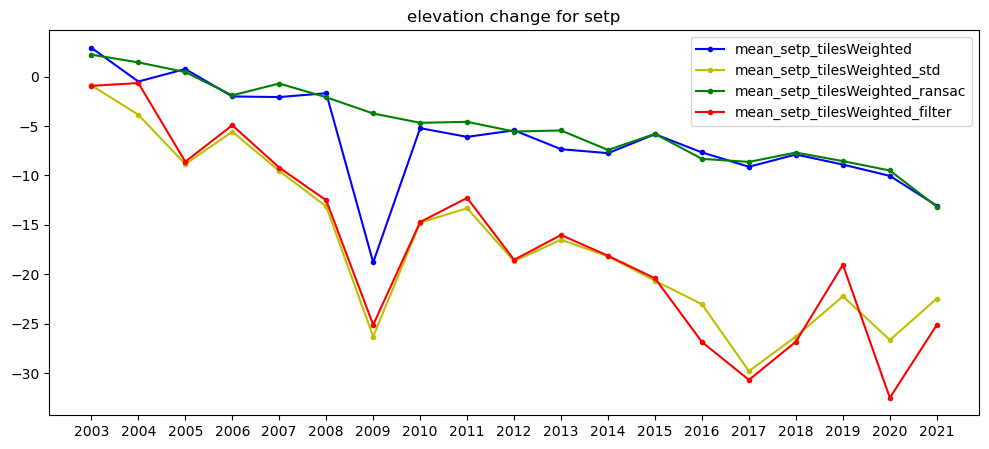

In [9]:
plt.figure(figsize=(12,5))
plt.plot(years, mean_setp_tilesWeighted, '.-b', label='mean_setp_tilesWeighted')
plt.plot(years, mean_setp_tilesWeighted_std, '.-y', label='mean_setp_tilesWeighted_std')
plt.plot(years, mean_setp_tilesWeighted_ransac, '.-g', label='mean_setp_tilesWeighted_ransac') ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_tilesWeighted_filter, '.-r', label='mean_setp_tilesWeighted_filter')
plt.legend()
plt.title('elevation change for setp')



#### 3. Visualize elevation change of each elevaiton bin.


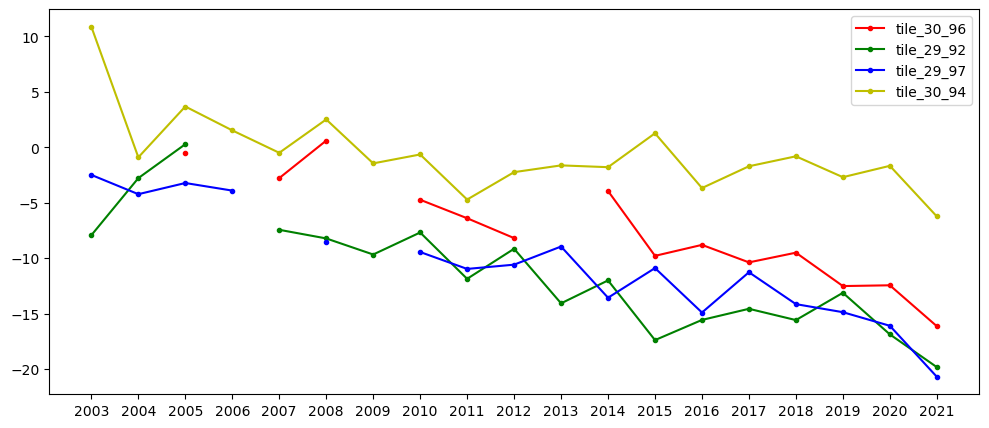

In [10]:
tile_id_1, tile_id_2, tile_id_3, tile_id_4 = 'tile_30_96', 'tile_29_92', 'tile_29_97', 'tile_30_94'
plt.figure(figsize=(12,5))
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_1), '.-r', label=tile_id_1)
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_2), '.-g', label=tile_id_2)
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_3), '.-b', label=tile_id_3)
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_4), '.-y', label=tile_id_4)
plt.legend()



### 4. Calculate elevation change of bins overall setp.

In [11]:
mean_bins_tilesWeighted_ransac, std_bins_tilesWeighted_ransac, mean_setp_binsWeighted_ransac, std_setp_binsWeighted_ransac = \
                                    ele_change_weighting_(mean_tiles_bins=mean_tiles_bins_ransac['mean_tiles_bins_filter'], \
                                                      std_tiles_bins=mean_tiles_bins_xr['std_tiles_bins'], 
                                                      glacier_area_tiles_bins=mean_tiles_bins_xr['glacier_area_bins'])


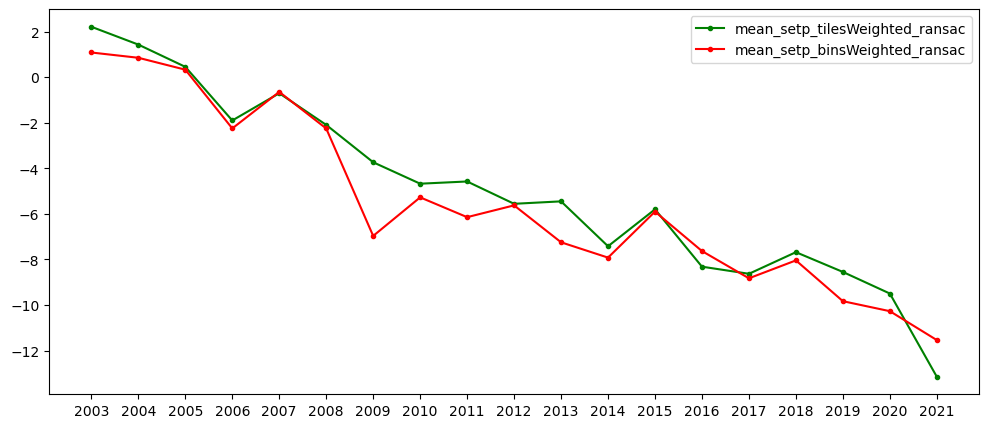

In [12]:
plt.figure(figsize=(12,5))
plt.plot(years, mean_setp_tilesWeighted_ransac, '.-g', label='mean_setp_tilesWeighted_ransac')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_binsWeighted_ransac, '.-r', label='mean_setp_binsWeighted_ransac')   ### tile-based area weighting -> bin-based area weighting
plt.legend()


Text(0.5, 1.0, 'selected tile')

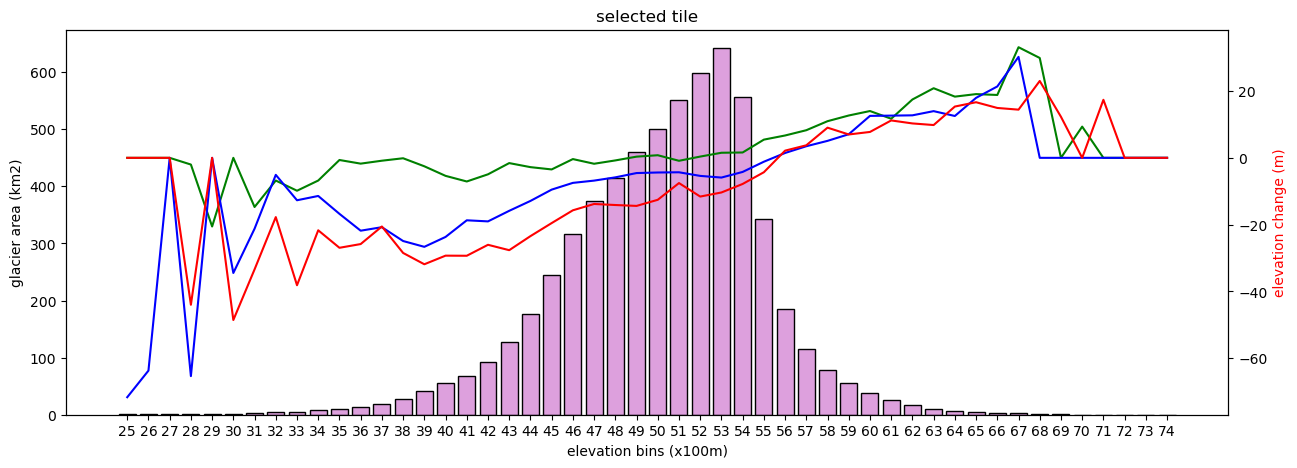

In [13]:
bins_id_start = [bin_id[0:2] for bin_id in bins_id]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax1.bar(bins_id_start, mean_tiles_bins_xr['glacier_area_bins'].sum(dim='tiles_id'), \
                                                          color ='Plum', edgecolor ='black')
ax1.set_ylabel('glacier area (km2)')
ax1.set_xlabel('elevation bins (x100m)')
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax2.set_ylabel('elevation change (m)', color='red')
ax2.plot(mean_bins_tilesWeighted_ransac.sel(time='2004'), 'g')
ax2.plot(mean_bins_tilesWeighted_ransac.sel(time='2012'), 'b')
ax2.plot(mean_bins_tilesWeighted_ransac.sel(time='2021'), 'r')
# plt.xticks([1, 25, 50], [2500, 5000, 7500])
plt.xlabel('elevation (m)')
plt.title('selected tile')

